In [24]:
import math
import numpy as np
import pandas as pd

# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [25]:
train = pd.read_csv("./data/train_all_features.csv")
# 查看样本总量
train.shape
# 查看good样本和bad样本数量,方便计算WOE
train["isFraud"].value_counts().values

(144233, 434)

array([132915,  11318])

In [26]:
# 获取缺失值超过95%的特征列并去除
percent_95NA_cols = [
    col for col in train.columns
    if sum(train[col].isnull()) / 144233 >=0.95
]
train = train.drop(percent_95NA_cols, axis=1)

### WOE编码

In [27]:
def get_col_woe_and_iv_score(col_name:str, train_df:pd.DataFrame):
    """
    根据特征列获取分箱后的woe值和iv值
    好样本数量:132915
    坏样本数量:11318
    Args:
        col_name (str): 获取woe值的特征列名
        train_df (DataFrame): 训练数据集

    return:
        bin_woe_map_value (dict): {bin_name : woe_score}
        train_df (DataFrame): 处理好的dataframe
    """
    col_name_df = train_df[[col_name,"isFraud"]]
    bin_woe_map_value = {}
    bin_iv_map_value = {}
    for value in train[col_name].unique():
        good_bin_cnt, bad_bi_cnt = col_name_df[col_name_df[col_name]==value]["isFraud"].value_counts().values
        woe = np.log(bad_bi_cnt / 11318) - np.log(good_bin_cnt / 132915)
        iv = ( (bad_bi_cnt / 11318) - (good_bin_cnt / 132915) ) * woe
        bin_woe_map_value[value] = woe
        bin_iv_map_value[value] = iv

    train_df[col_name+"_woe"] = train_df[col_name].map(bin_woe_map_value)
    train_df[col_name+"_iv"] = train_df[col_name].map(bin_iv_map_value)
    train_df.drop(col_name,axis=1,inplace=True)

    return train_df,bin_woe_map_value,bin_iv_map_value

- 自定义分箱

(array([  1448.,    311.,    307.,    199.,    739.,   2861.,   3027.,
          5345.,  16983., 113013.]),
 array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
         -10.,    0.]),
 <BarContainer object of 10 artists>)

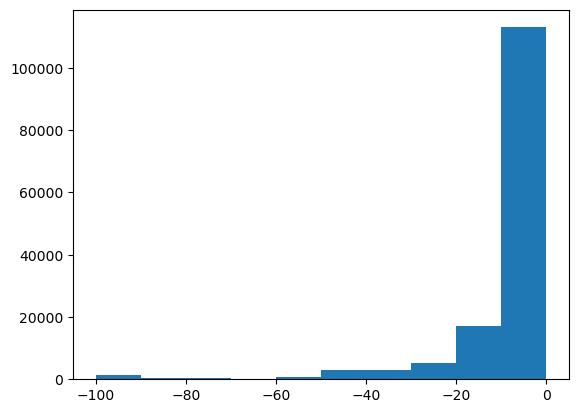

'\n    bin1: -10 <= x < 0\n    bin2: -50 <= x < -10\n    bin3: x < -50\n'

In [28]:
# 找出连续特征列,从中任取3列做等频分箱WOE、等距分箱WOE和自定义分箱WOE
continues_cols = [
    col for col in train.columns
    if train[col].dtype == 'float64'
]

# 自定义分箱WOE,查看特征分布
import matplotlib.pyplot as plt
plt.hist(train['id_01'])
plt.show()

"""
    bin1: -10 <= x < 0
    bin2: -50 <= x < -10
    bin3: x < -50
"""
train["id_01_customize_bins"] = train["id_01"].apply(lambda x:
                               'bin1_-10_0' if -10<= x <0 else
                               'bin2_-50_-10' if -50<= x <-10 else
                               'bin_3_less_than_-50' 
                                )
train, id_01_customize_bins_woe_map, id_01_customize_bins_iv_map = get_col_woe_and_iv_score("id_01_customize_bins", train)

In [29]:
id_01_customize_bins_woe_map
id_01_customize_bins_iv_map

{'bin_3_less_than_-50': -0.1524215963976605,
 'bin1_-10_0': -0.19683304720295225,
 'bin2_-50_-10': 0.5635844950204418}

{'bin_3_less_than_-50': 0.00340812441729534,
 'bin1_-10_0': 0.023112082374741886,
 'bin2_-50_-10': 0.07877760290433763}

In [46]:
sum(id_01_customize_bins_iv_map.values())

0.10529780969637487

- 等距分箱

In [30]:
# 等距分箱
def get_equal_interval_bins(column:str, train:pd.DataFrame, bins=8):
    """等距分箱并返回结果

    Args:
        column (str): 特征列名
        train (pd.DataFrame): 训练数据
        bins (int, optional): 分箱数量一般采用5-10箱. Defaults to 8.

    return:
        分箱后的dataframe
    """
    minValue = train[column].min()
    maxValue = train[column].max()
    bin_interval = (maxValue - minValue) / bins

    def _apply_bin_func(value):
        bin_num = math.floor((value - minValue) / bin_interval)
        if bin_num < 8:
            bin_left = minValue + bin_num * bin_interval
            bin_right = minValue + (bin_num+1) * bin_interval

            bin_name = f"{column}_{bin_num}_{bin_left}_{bin_right}"
        else:
            bin_left = maxValue - bin_interval

            bin_name = f"{column}_{7}_{bin_left}_{maxValue}"

        return bin_name
        

    train[f"{column}_equal_interval_bins"] = train[f"{column}"].apply(lambda x: "NAN" if pd.isna(x) else _apply_bin_func(x))
                               
    return train

In [31]:
train = get_equal_interval_bins("id_02", train)
train["id_02_equal_interval_bins"].value_counts()

id_02_0_1.0_124950.25         70006
id_02_1_124950.25_249899.5    39958
id_02_2_249899.5_374848.75    15841
id_02_3_374848.75_499798.0     7559
id_02_4_499798.0_624747.25     3975
NAN                            3361
id_02_5_624747.25_749696.5     1886
id_02_6_749696.5_874645.75     1056
id_02_7_874645.75_999595.0      591
Name: id_02_equal_interval_bins, dtype: int64

In [32]:
train, id_02_equal_interval_woe_map, id_02_equal_interval_iv_map = get_col_woe_and_iv_score("id_02_equal_interval_bins", train)

In [33]:
sorted(id_02_equal_interval_bins_woe_map.items(),key=lambda x:x[1])
sorted(id_02_equal_interval_iv_map.items(),key=lambda x:x[1])

[('NAN', -1.0633514027956514),
 ('id_02_0_1.0_124950.25', -0.15145017071321587),
 ('id_02_1_124950.25_249899.5', 0.0671116684769757),
 ('id_02_6_749696.5_874645.75', 0.13759577905134002),
 ('id_02_2_249899.5_374848.75', 0.19975269586234257),
 ('id_02_5_624747.25_749696.5', 0.3202828029856759),
 ('id_02_3_374848.75_499798.0', 0.34458205789659724),
 ('id_02_4_499798.0_624747.25', 0.37706343676468057),
 ('id_02_7_874645.75_999595.0', 0.5944386748745565)]

[('id_02_6_749696.5_874645.75', 0.0001469035821658984),
 ('id_02_1_124950.25_249899.5', 0.0012836026534191714),
 ('id_02_5_624747.25_749696.5', 0.0015355674481176166),
 ('id_02_7_874645.75_999595.0', 0.001859372008841442),
 ('id_02_4_499798.0_624747.25', 0.0045942552802985),
 ('id_02_2_249899.5_374848.75', 0.004767936695091916),
 ('id_02_3_374848.75_499798.0', 0.007197106580208303),
 ('id_02_0_1.0_124950.25', 0.01044610119123453),
 ('NAN', 0.01710135677628283)]

In [34]:
sum(id_02_equal_interval_iv_map.values())

0.0489322022156602

- 等频分箱

In [35]:
train["id_03"].value_counts(dropna=False)

 NaN     77909
 0.0     63903
 1.0       863
 3.0       668
 2.0       421
 5.0       109
 4.0       100
 6.0        64
-5.0        33
-6.0        31
-7.0        21
-4.0        21
-10.0       17
-8.0        14
-2.0        12
-1.0        12
-3.0         8
-9.0         6
-11.0        6
 7.0         4
 9.0         3
-12.0        3
-13.0        3
 10.0        1
 8.0         1
Name: id_03, dtype: int64

In [36]:
# 等频分箱
def get_equal_frequence_bins(column:str, train:pd.DataFrame, bins=8):
    """等频分箱并返回结果

    Args:
        column (str): 特征列名
        train (pd.DataFrame): 训练数据
        bins (int, optional): 分箱数量一般采用5-10箱. Defaults to 8.

    return:
        分箱后的dataframe
    """
    percentiles = np.linspace(0,1,bins+1)
    splits = np.percentile(train[column], percentiles * 100)

    def _apply_bin_func(value):
        if pd.isna(value):
            bin_name = "NAN"
        else:
            bin_name=''
            for i in range(bins):
                if splits[i] <= value < splits[i+1]:
                    bin_name = f"{column}_frequence_bin_{i}"
            if not bin_name:
                bin_name = f"{column}_frequence_bin_{bins-1}"

        return bin_name       

    train[f"{column}_equal_frequence_bins"] = train[f"{column}"].apply(lambda x: _apply_bin_func(x))
                               
    return train

In [37]:
train = get_equal_frequence_bins("id_03", train)
train, id_03_equal_frequence_woe_map, id_03_equal_frequence_iv_map = get_col_woe_and_iv_score("id_03_equal_frequence_bins", train)

In [38]:
sorted(id_03_equal_frequence_woe_map.items(), key=lambda x : x[1])
sorted(id_03_equal_frequence_iv_map.items(), key=lambda x : x[1])

[('NAN', -0.40021597920238416), ('id_03_frequence_bin_7', 0.34397472160740106)]

[('id_03_frequence_bin_7', 0.06291017478690321), ('NAN', 0.0731962426962013)]

In [48]:
sum(id_03_equal_frequence_iv_map.values())

0.1361064174831045

In [39]:
# qcut分箱
train_id_03_bins = pd.qcut(train["id_03"], q=5, labels=False, duplicates='drop')
train_id_03_bins.value_counts(dropna=False)

NaN    77909
0.0    64090
1.0     2234
Name: id_03, dtype: int64

# 决策树规则生成

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf = DecisionTreeClassifier(max_depth=3)
X = train[["id_01_customize_bins_woe", "id_02_equal_interval_bins_woe", "id_03_equal_frequence_bins_woe"]]
y = train["isFraud"]

clf.fit(X,y)

DecisionTreeClassifier(max_depth=3)

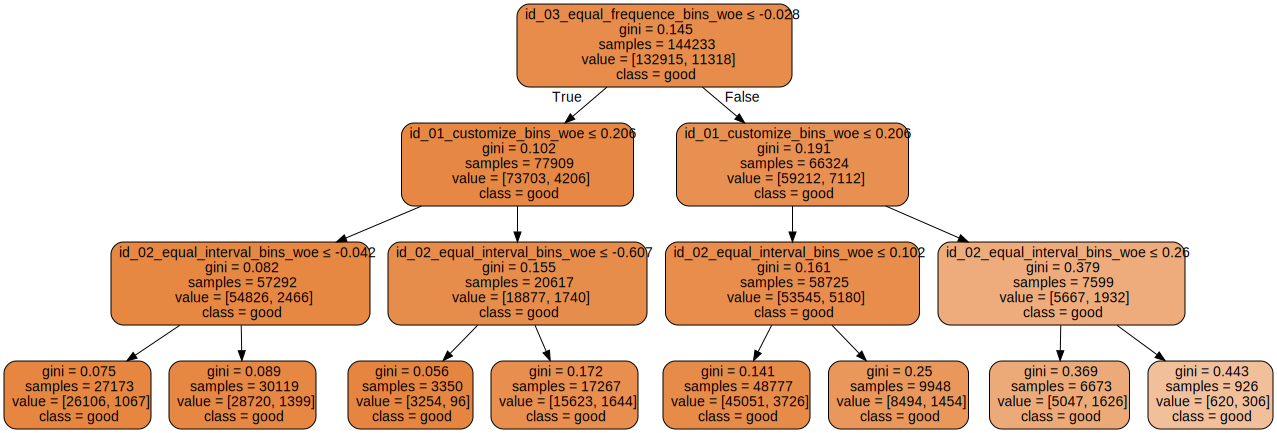

In [42]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(
            clf,
            out_file=None,
            feature_names=X.columns,
            class_names=["good", "bad"],
            filled=True, rounded=True,
            special_characters=True
            )
graph = graphviz.Source(dot_data)
graph

In [43]:
from sklearn.tree import _tree

def DT_Get_Rules(clf, X):
    n_nodes = clf.tree_.node_count # 树的节点数
    children_left = clf.tree_.children_left # 树节点的左孩子
    children_right = clf.tree_.children_right # 树节点的右孩子
    feature = clf.tree_.feature # 节点的特征索引
    threshold = clf.tree_.threshold # 节点的阈值
    value = clf.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0,0)] # (id, depth)

    while len(stack)>0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        is_spilt_node = children_left[node_id] != children_right[node_id] # 判断是否为中间结点，当左右节点都为None的时候为叶子结点，正常结点的左右孩子结点不一样

        if is_spilt_node:
            stack.append((children_left[node_id], depth+1)) # 当前节点的左子树入栈
            stack.append((children_right[node_id], depth+1)) # 当前节点的右子树入栈
        else:
            is_leaves[node_id] = True
    
    feature_name = [X.columns[i] if i != _tree.TREE_UNDEFINED else "undefined" for i in feature]
    ways = []
    depth = []
    feat = []
    nodes = []
    rules = []
    for i in range(n_nodes):
        if is_leaves[i]:
            while depth[-1] >= node_depth[-1]:
                depth.pop()
                ways.pop()
                feat.pop()
                nodes.pop()
            if children_left[i-1] == i: # 当前节点是上一个节点的左节点时；小于
                a = "{f}<={th}".format(f=feat[-1], th=round(threshold[nodes[-1]], 4))
                ways[-1] = a
                last = '&'.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)
            else:
                a = "{f}>{th}".format(f=feat[-1], th=round(threshold[nodes[-1]], 4))
                ways[-1] = a
                last = '&'.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)
        else: # 不是叶子结点，入栈
            if i==0:
                ways.append(round(threshold[i], 4))
                depth.append(node_depth[i])
                feat.append(feature_name[i])
                nodes.append(i)
            else:
                while depth[-1] >= node_depth[i]:
                    depth.pop()
                    ways.pop()
                    feat.pop()
                    nodes.pop()
                if i==children_left[nodes[-1]]:
                    w = "{f}<={th}".format(f=feat[-1], th=round(threshold[nodes[-1]], 4))
                else:
                    w = "{f}>{th}".format(f=feat[-1], th=round(threshold[nodes[-1]], 4))
                ways[-1] = w
                ways.append(round(threshold[i], 4))
                depth.append(node_depth[i])
                feat.append(feature_name[i])
                nodes.append(i)

    return rules

In [44]:
rules = DT_Get_Rules(clf, X)

In [45]:
rules

['id_03_equal_frequence_bins_woe<=-0.0281&id_01_customize_bins_woe<=0.2056&id_02_equal_interval_bins_woe<=-0.0422:26106.0:1067.0',
 'id_03_equal_frequence_bins_woe<=-0.0281&id_01_customize_bins_woe<=0.2056&id_02_equal_interval_bins_woe>-0.0422:28720.0:1399.0',
 'id_03_equal_frequence_bins_woe<=-0.0281&id_01_customize_bins_woe>0.2056&id_02_equal_interval_bins_woe<=-0.6074:3254.0:96.0',
 'id_03_equal_frequence_bins_woe<=-0.0281&id_01_customize_bins_woe>0.2056&id_02_equal_interval_bins_woe>-0.6074:15623.0:1644.0',
 'id_03_equal_frequence_bins_woe>-0.0281&id_01_customize_bins_woe<=0.2056&id_02_equal_interval_bins_woe<=0.1024:45051.0:3726.0',
 'id_03_equal_frequence_bins_woe>-0.0281&id_01_customize_bins_woe<=0.2056&id_02_equal_interval_bins_woe>0.1024:8494.0:1454.0',
 'id_03_equal_frequence_bins_woe>-0.0281&id_01_customize_bins_woe>0.2056&id_02_equal_interval_bins_woe<=0.26:5047.0:1626.0',
 'id_03_equal_frequence_bins_woe>-0.0281&id_01_customize_bins_woe>0.2056&id_02_equal_interval_bins_woe